# Trawl processes example usage

The full documentation can be found at [link].
    
### Table of Contents

1. Simulation

    1.1. Slice  
    1.2. Grid  
    1.3. Cpp
    
    
2. Parameter inference    
3. Forecasting  

In [105]:
%matplotlib inline
#module imports
import numpy as np
#import time 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm,gamma
#import statsmodels.api as sm
from scipy.integrate import quad
#from scipy import stats

import matplotlib.pyplot as plt
#from pandas.plotting import lag_plot
from ambit_stochastics.trawl import trawl
  
plt.style.use('ggplot')

## 1. Simulation

Consider a homogeneous Levy basis $L$ and an ambit set $A$ of finite Lebesgue measure given by
\begin{equation*}
    A_t = A + (t,0), \qquad A = \{(s,x) \in \mathbb{R}^2 \colon  s<0, 0 < x < \phi(s) \},
\end{equation*}
where $\phi \colon (-\infty,0] \to \mathbb{R}_{\ge 0}$ is any increasing, convex and continuous function. We refer to $\phi$ as the trawl function. We simulate the trawl process $$X_t= L(A_t) = L(A + (t,0))$$ at given times $\tau_1, \ldots,\tau_k$ by simulating the Gaussian and jump parts separately. For the slice partition, we assume that the times are equidistant, i.e. $\tau_1 =\tau, \tau_2 = 2 \tau, \ldots, \tau_k = k \tau$. If the times are not equidistant, please consider oemploying the grid or cpp algorithms.

We first instantiate a trawl class and then use the `simulate` function

trawl_instance.simulate(method)

where the input `method` is one of the strings 'slice','grid' or 'cpp'. All the three simulation methods requires the following arguments: `nr_trawls`,`nr_simulations`,    `trawl_function` and `gaussian_part_params`.
        
        
### 1.1 Slice method



In the slice method, we consider equidistant times $\tau_1,\ldots,\tau_k = \tau, \ldots,k \tau.$ If the ambit set $A$ is compactly supported, we set `decorrelation_time` $= \sup\left\{T <0: \phi(T) =0\right\},$ otherwise we set it be $-\infty.$

In the following, we let $\tau=0.2,k=1000, \phi \colon [-1,0] \to \mathbb{R}, \phi(x) = (1+x)$ and `decorrelation_time`$=-1$. 
Then $\mathrm{Leb}(A) = 0.5$ and the marginal distribution of this trawl process is given by the sum of independent random variables distributed as
$$\mathcal{N}(-3\ \textrm{Leb}(A),7 \ \textrm{Leb}(A)^{0.5}) + \text{Gamma}(2\  \textrm{Leb}(A),3) = \mathcal{N}(-1.5,3.5 \sqrt{2}) + Gamma(1,3) $$

where the distributions are parametrised as in [scipy](https://docs.scipy.org/doc/scipy/reference/stats.html). We perform $50$ simulations. 

In [90]:
tau = 0.2
nr_trawls = 1000  #this is k
nr_simulations = 50
trawl_function_slice_1 = lambda x :  (x>-1) * (x<=0) * (1+x) 
decorrelation_time_slice_1 = -1
gaussian_part_params = (-3,7)
jump_part_params = (2,3)
jump_part_name   = 'gamma' #can be None,'cauchy','invgauss','poisson' (more to be implemented)

In [91]:
trawl_slice_1 = trawl(nr_trawls = nr_trawls, nr_simulations = nr_simulations,trawl_function = trawl_function_slice_1,tau =  tau,
                   decorrelation_time =  decorrelation_time_slice_1, gaussian_part_params = gaussian_part_params,
                   jump_part_name =  jump_part_name,jump_part_params = jump_part_params)   
trawl_slice_1.simulate(method='slice',slice_convolution_type='fft')

The  simulated values are stored in the `values`,`gaussian_values` and `jump_values` attributes of the trawl class, which have shapes given by [`nr_simulations`,`nr_tralws`]. The `values` attribute is the sum of the other two attributes.

In [92]:
np.array_equal(trawl_slice_1.values, trawl_slice_1.gaussian_values + trawl_slice_1.jump_values)

True

Text(0.5, 0.98, 'Realisations of the trawl process')

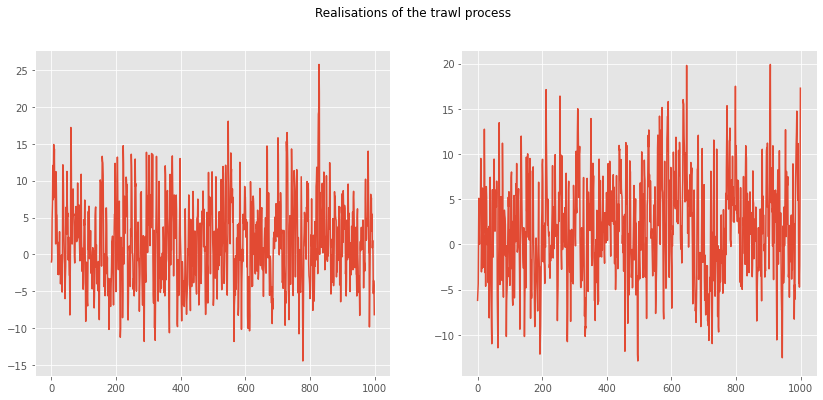

In [93]:
f,ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(trawl_slice_1.values[0])
ax[1].plot(trawl_slice_1.values[1])
f.suptitle('Realisations of the trawl process')

If the `decorrelation_time` attribute is $-\infty,$ the algorithm used is [to add], otherwise it is [to add]. The matrix of areas as given in [] and [] can be found in the `slice_areas_matrix` attribute. This matrix is `nr_trawls` by `nr_tralws` in the infinite decorrelation time case and $I$ by $I$ otherwise, where $I$ is equal to the celing of -`decorrelation_time`/`tau`. Exactly $I$ consecutive ambit sets have non-empty intersection.

In [94]:
print('The decorrelation time is ',trawl_slice_1.decorrelation_time)
print('\n The matrix of areas is \n\n',trawl_slice_1.slice_areas_matrix)
print('\nI is ',trawl_slice_1.I)

The decorrelation time is  -1

 The matrix of areas is 

 [[0.18 0.04 0.04 ... 0.04 0.04 0.04]
 [0.14 0.04 0.04 ... 0.04 0.04 0.04]
 [0.1  0.04 0.04 ... 0.04 0.04 0.04]
 [0.06 0.04 0.04 ... 0.04 0.04 0.04]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]]

I is  5


we can check that the empirical acf of the simulated trawls agrees with the theoretical ones.

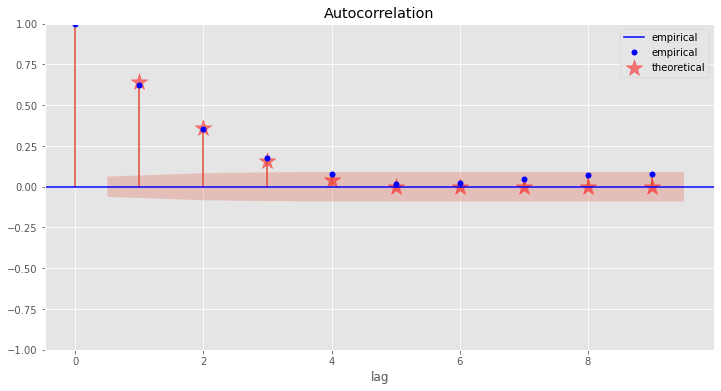

In [118]:
fig_acf, ax_acf = plt.subplots(1,1,figsize=(12,6))
plot_acf(trawl_slice_1.values[1], lags = 9, ax=ax_acf, color = 'blue', label='empirical')
ax_acf.set_xlabel('lag')
x = np.arange(1,10,1)
y = trawl_slice_1.theoretical_acf(np.arange(1,10,1)*trawl_slice_1.tau)

ax_acf.scatter(x,y.values(),marker = "*", color = 'r',s = 300,alpha = 0.5,label='theoretical')
ax_acf.legend()

We can also consider the infintie decorrelation time case.


In [95]:
trawl_function_slice_2 =  lambda x : np.exp(x/5) * (x<=0)
decorrelation_time_slice_2 = -np.inf

trawl_slice_2 = trawl(nr_trawls = nr_trawls, nr_simulations = nr_simulations,trawl_function = trawl_function_slice_2,tau =  tau,
                   decorrelation_time =  decorrelation_time_slice_2, gaussian_part_params = gaussian_part_params,
                   jump_part_name =  jump_part_name,jump_part_params = jump_part_params)   
#trawl_slice_2.simulate(method='slice') #to delete the second argument

### 1.2  Grid method

In this algorithm, we discretize the rectangle $[\tau_1+\text{truncation_grid},\tau_k] \times [0,\phi(0)]$ into a grid of cells, simulate the L\'evy basis over these cells and approximate $L(A)$ by $\sum{L(c)},$ where the sum is over cells $c$ which are contained in $A.$  If the ambit set $A$ is bounded, the parameter `truncation_grid` is the same as `decorrelation_time` from the slice algorithm, otherwise `truncation_grid`  dictates how much of the ambit set we neglect (see figure from ). The finer the `mesh_size`, the smaller the approximation error of the simulation.

In [96]:
nr_trawls = 1000 #same as k
nr_simulations = 50
trawl_function_grid = lambda x :  (x> -2) * (x<=0) * (2 - (-x) **2/2) 
gaussian_part_params = (-3,7)
jump_part_params = (2,3)
jump_part_name   = 'gamma'
mesh_size = 0.05
truncation_grid = -2
times_grid =  tau * np.arange(1,nr_trawls+1,1)#doesn't have to be equally spaced


In [97]:
trawl_grid  = trawl(nr_trawls = nr_trawls, nr_simulations = nr_simulations,trawl_function = trawl_function_grid,
                   times_grid=times_grid,mesh_size = mesh_size,truncation_grid = truncation_grid,
                   gaussian_part_params = gaussian_part_params, jump_part_name =  jump_part_name,
                   jump_part_params = jump_part_params )


In [98]:
trawl_grid.simulate(method='grid')

Text(0.5, 0.98, 'Realisations of the trawl process')

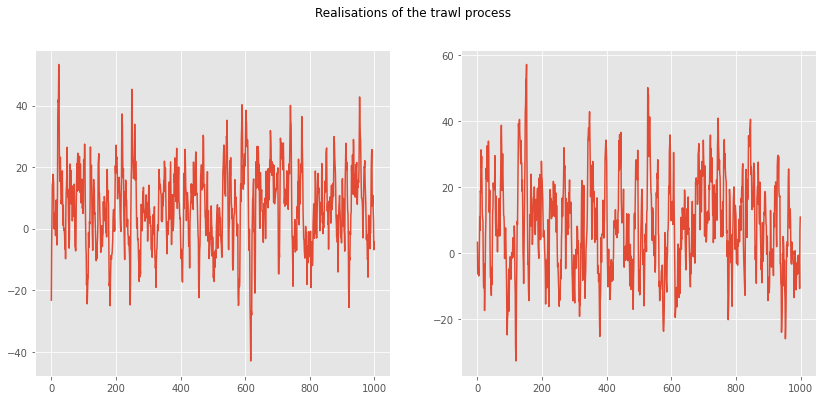

In [99]:
f,ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(trawl_grid.values[0])
ax[1].plot(trawl_grid.values[1])
f.suptitle('Realisations of the trawl process')

#Even if we have the same parameters for the Gaussian and jump part, the marginal distribution of the trawl process is 
#different, because the Lebesgue measure of the ambit set is different. 

we can check that the marginal distribution of the simulated trawls agrees with the theoretical ones. We infer the distribution of the Gaussian and jump parts via mle, then adjust the obatined value by dividing by the area of the ambit set. We plot the histogram obtained below.

Text(0.5, 0.98, 'Gaussian params')

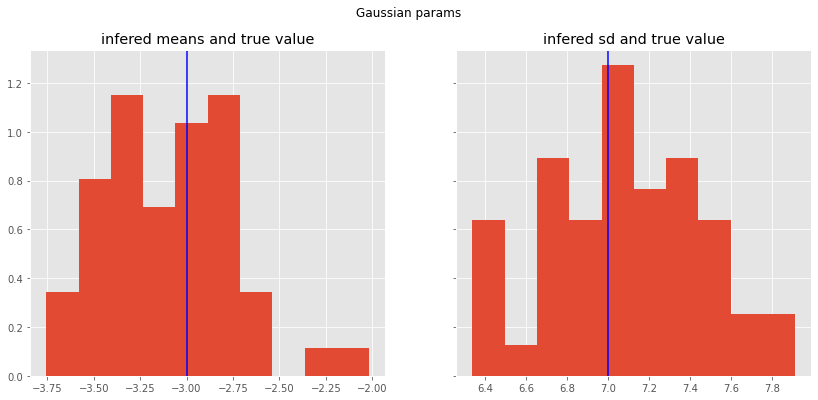

In [131]:
a = [norm.fit(data = trawl_grid.gaussian_values[simulation,:]) for simulation in range(trawl_grid.nr_simulations)]
total_area_grid = quad(trawl_grid.trawl_function,a=-np.inf,b=0)[0]
a = np.array(a) / np.array([total_area_grid, total_area_grid ** 0.5])
    
f,ax= plt.subplots(1,2,sharey=True,figsize=(14,6))
ax[0].hist(a[:,0],density=True)
ax[0].set_title('infered means and true value')
    
ax[1].hist(a[:,1],density=True)
ax[1].set_title('infered sd and true value')
    
ax[0].axvline(x=trawl_grid.gaussian_part_params[0],color='b')
ax[1].axvline(x=trawl_grid.gaussian_part_params[1],color='b')
f.suptitle('Gaussian params')
#true vlaue is shown in blue

Text(0.5, 0.98, 'Gamma parameters')

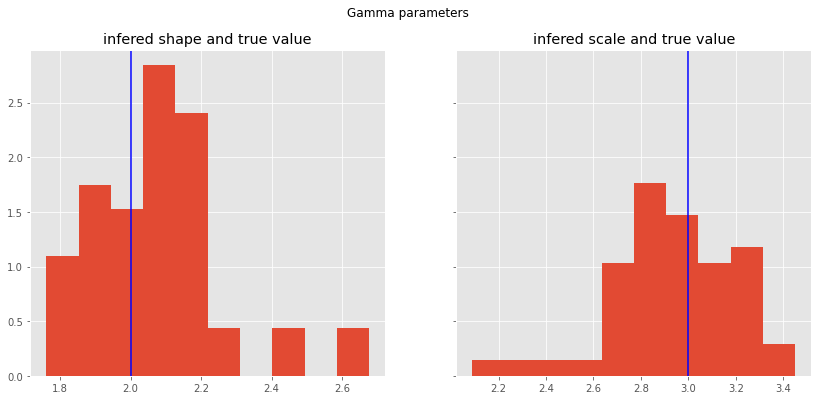

In [134]:
a = [gamma.fit(data = simulation,floc=0) for simulation in trawl_grid.jump_values]
a = np.array([[i[0],i[2]] for i in a])   #a, scale
a = a / np.array([total_area_grid,1])
        
f_gamma,ax_gamma= plt.subplots(1,2,sharey=True, figsize=(14,6))
ax_gamma[0].hist(a[:,0],density=True)
ax_gamma[0].set_title('infered shape and true value')
        
ax_gamma[1].hist(a[:,1],density=True)
ax_gamma[1].set_title('infered scale and true value')
        
ax_gamma[0].axvline(x=trawl_grid.jump_part_params[0],color='b')
ax_gamma[1].axvline(x=trawl_grid.jump_part_params[1],color='b')
f_gamma.suptitle('Gamma parameters')
#true vlaue is shown in blue

### 1.3 Cpp simulation

### Appendix
#### Scaling
Gaussian L\'evy basis

Let $L^{'}\sim \mathcal{N}(\mu,\sigma)$ be Gaussian distributed with mean $\mu$ and variance $\sigma^2.$ Then $X_t = L(A_t) \sim \mathcal{N}\left(\mu \mathrm{Leb}\left(A\right), \sigma^2 \mathrm{Leb}\left(A\right)\right).$


Gamma L\'evy basis
Let $L^{'} \sim \text{Gamma}(\alpha,\beta)$ with shape and rate parameters $\alpha,\beta >0$ and pdf
\begin{equation*}
    p(x) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x}, \ x>0.
\end{equation*}
Then $X_t = L(A_t) \sim \text{Gamma}(\alpha \mathrm{Leb}\left(A\right),\beta).$
